<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Pre-sets" data-toc-modified-id="Pre-sets-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Pre-sets</a></span></li></ul></li><li><span><a href="#Collecting-Data" data-toc-modified-id="Collecting-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Collecting Data</a></span><ul class="toc-item"><li><span><a href="#COVID19" data-toc-modified-id="COVID19-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>COVID19</a></span></li><li><span><a href="#Climate" data-toc-modified-id="Climate-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Climate</a></span><ul class="toc-item"><li><span><a href="#Retrieval-from-CDS-API" data-toc-modified-id="Retrieval-from-CDS-API-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Retrieval from CDS API</a></span></li></ul></li></ul></li><li><span><a href="#Data-Processing" data-toc-modified-id="Data-Processing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Processing</a></span><ul class="toc-item"><li><span><a href="#Climate" data-toc-modified-id="Climate-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Climate</a></span><ul class="toc-item"><li><span><a href="#Filtering-relevant-coords" data-toc-modified-id="Filtering-relevant-coords-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Filtering relevant coords</a></span></li><li><span><a href="#Coords-->-Country-assignation" data-toc-modified-id="Coords-->-Country-assignation-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Coords -&gt; Country assignation</a></span></li><li><span><a href="#Computation-of-humidity-and-daily-means" data-toc-modified-id="Computation-of-humidity-and-daily-means-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>Computation of humidity and daily means</a></span></li><li><span><a href="#Weighted-averages-by-population-density" data-toc-modified-id="Weighted-averages-by-population-density-3.1.4"><span class="toc-item-num">3.1.4&nbsp;&nbsp;</span>Weighted averages by population density</a></span></li></ul></li><li><span><a href="#Selection-of-relevant-dates" data-toc-modified-id="Selection-of-relevant-dates-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Selection of relevant dates</a></span></li><li><span><a href="#Weather-averages-for-the-selected-days" data-toc-modified-id="Weather-averages-for-the-selected-days-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Weather averages for the selected days</a></span><ul class="toc-item"><li><span><a href="#Generating-figures" data-toc-modified-id="Generating-figures-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Generating figures</a></span></li></ul></li></ul></li><li><span><a href="#$R_0$-Estimation" data-toc-modified-id="$R_0$-Estimation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>$R_0$ Estimation</a></span></li><li><span><a href="#$R_0$-~-weather-comparison" data-toc-modified-id="$R_0$-~-weather-comparison-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>$R_0$ ~ weather comparison</a></span><ul class="toc-item"><li><span><a href="#Temperature" data-toc-modified-id="Temperature-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Temperature</a></span></li><li><span><a href="#Absolute-Humidity" data-toc-modified-id="Absolute-Humidity-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Absolute Humidity</a></span></li><li><span><a href="#Sensitivity-analysis" data-toc-modified-id="Sensitivity-analysis-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Sensitivity analysis</a></span></li></ul></li></ul></div>

# Comparison of initial COVID19 spread and local weather

## Preamble

### Imports

In [1]:
import os
import sys
import cdsapi

In [2]:
# Since we share the source code module in a same level folder:
sys.path.append('..')

In [9]:
import numpy as np
import pandas as pd
import xarray as xr
import plotnine as p9
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from tqdm import tqdm
from atmos import calculate
from shapely.geometry import Point, MultiPolygon
from collections import defaultdict
from metpy.calc import relative_humidity_from_dewpoint
from mizani.formatters import date_format, percent_format

from src import CV_LABELS
from src.utils import region_assign
from src.fits import ExponentialFit, CountryFittedComparison

### Pre-sets

In [4]:
p9.options.set_option("dpi", 150)
plt.style.use("seaborn-whitegrid")
plt.ioff()
plt.rcParams['svg.fonttype'] = 'none'
p9.theme_set(p9.theme_bw)
tqdm.pandas()

## Collecting Data

### COVID19

We fetch the COVID19 daily cases from the ECDC's open data repository:

In [16]:
ecdc_link = "https://opendata.ecdc.europa.eu/covid19/casedistribution/csv"

covid_df = (pd.read_csv(ecdc_link)
            .assign(date=lambda dd: pd.to_datetime(dd.dateRep, dayfirst=True))
            .assign(country=lambda dd: dd['countriesAndTerritories'].str.replace('_', ' '))
            .rename(columns={'countryterritoryCode': 'iso3', 'popData2019': 'population'})
            .groupby('country')
            .apply(lambda dd: dd.sort_values('date')
                                .assign(cumulative_cases=lambda dd: dd.cases.cumsum(),
                                        cumulative_deaths=lambda dd: dd.deaths.cumsum()))
            .reset_index(drop=True)
            [['date', 'country', 'iso3', 'population', 'cases', 'cumulative_cases',
              'deaths', 'cumulative_deaths']]
           )

We will keep a cached version of the full table at `2021-05-26` for consistency purposes

In [6]:
covid_df.to_csv('../../data/covid19/covid_world.csv', index=False)

In [5]:
covid_df = pd.read_csv('../../data/covid19/covid_world.csv')

If we take a look at how the first 20 days look for Spain after surpassing the 20 confirmed COVID-19 cases:

In [6]:
covid_df.query('iso3 == "ESP" & cumulative_cases >= 20').head(20)

date country iso3  population  cases  cumulative_cases  deaths  \
52782  2020-02-28   Spain  ESP  46937060.0     18                35       0   
52783  2020-02-29   Spain  ESP  46937060.0     19                54       0   
52784  2020-03-01   Spain  ESP  46937060.0     28                82       0   
52785  2020-03-02   Spain  ESP  46937060.0     54               136       0   
52786  2020-03-03   Spain  ESP  46937060.0     56               192       0   
52787  2020-03-04   Spain  ESP  46937060.0     75               267       0   
52788  2020-03-05   Spain  ESP  46937060.0     81               348       1   
52789  2020-03-06   Spain  ESP  46937060.0    183               531       2   
52790  2020-03-07   Spain  ESP  46937060.0    233               764       2   
52791  2020-03-08   Spain  ESP  46937060.0    330              1094       0   
52792  2020-03-09   Spain  ESP  46937060.0    433              1527       0   
52793  2020-03-10   Spain  ESP  46937060.0    772              2299      23   
52794  2020-03-11   Spain  ESP  46937060.0    975              3274       7   
52795  2020-03-12   Spain  ESP  46937060.0   1153              4427      12   
52796  2020-03-13   Spain  ESP  46937060.0   1531              5958      37   
52797  2020-03-14   Spain  ESP  46937060.0   1683              7641      37   
52798  2020-03-15   Spain  ESP  46937060.0   2144              9785      15   
52799  2020-03-16   Spain  ESP  46937060.0   1706             11491     152   
52800  2020-03-17   Spain  ESP  46937060.0   2503             13994      21   
52801  2020-03-18   Spain  ESP  46937060.0   3694             17688     182   

       cumulative_deaths  
52782                  0  
52783                  0  
52784                  0  
52785                  0  
52786                  0  
52787                  0  
52788                  1  
52789                  3  
52790                  5  
52791                  5  
52792                  5  
52793                 28  
52794                 35  
52795                 47  
52796                 84  
52797                121  
52798                136  
52799                288  
52800                309  
52801                491

### Climate

We are fetching the weather data from the Copernicus Climate Data Store, which gives us access to (among others) the ERA5 hourly data on single levels from 1979 to present. We download the grid at a 0.5x0.5 degree resolution directly through the API.

Given that these files are rather heavy and we want to be able to handle them in a not too memory-heavy manner, we will split the downloads in batches of 10 days. I will download the full batch of data starting in February 2020 up to April 2021 with these API calls, but we will only use data from Feb-Jul 2020 in this notebook.

For the API calls to work, a client needs to be instantiated which will read the private keys in `/home/$USER/.cdsapirc`, so this won't work in Code Ocean:

#### Retrieval from CDS API

In [33]:
c = cdsapi.Client()

In [ ]:
year_months = {'2020': [str(i).zfill(2) for i in range(2, 13)],
               '2021': [str(i).zfill(2) for i in range(5)]}

for years, months in year_months.items():
    for month in months:

        for i, days in enumerate([list(range(1, 11)),
                                  list(range(11, 21)),
                                  list(range(21, 32))]):
            c.retrieve(
                'reanalysis-era5-single-levels',
                {
                    'product_type': 'reanalysis',
                    'format': 'netcdf', 
                    'grid': [.5, .5],
                    'variable': [
                        '2m_dewpoint_temperature',
                        '2m_temperature',
                        'mean_sea_level_pressure',
                        'total_precipitation',
                    ],
                    'year': year,
                    'month': [month],
                    'day': [str(d).zfill(2) for d in days],
                    'time': [
                        '00:00', '01:00', '02:00',
                        '03:00', '04:00', '05:00',
                        '06:00', '07:00', '08:00',
                        '09:00', '10:00', '11:00',
                        '12:00', '13:00', '14:00',
                        '15:00', '16:00', '17:00',
                        '18:00', '19:00', '20:00',
                        '21:00', '22:00', '23:00',
                    ],

                },
                f'../../data/era5/world/{year}_{month}_{i}_weather.nc')

## Data Processing

### Climate

#### Filtering relevant coords

In [7]:
lon_lat = (xr.load_dataset('../../data/era5/world/2020_02_0_weather.nc')
           .to_dataframe()
           .reset_index()
           [['longitude', 'latitude']]
           .drop_duplicates()
           .assign(longitude=lambda dd: dd.longitude.apply(lambda x: x if x < 180 else x - 360))
          )

In [6]:
world = (gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) 
         .rename(columns={'iso_a3': 'iso3', 'name': 'country'})
         .loc[lambda dd:  ~dd.country.isin(['Antarctica'])]
        )

In [7]:
world.loc[lambda dd: dd.country=='France', 'iso3'] = 'FRA'
world.loc[lambda dd: dd.country=='Norway', 'iso3'] = 'NOR'
world.loc[lambda dd: dd.country=='Kosovo', 'iso3'] = 'XKX'

France's territory in our shapefile includes French Guyana in South America, which might bias the weather variables to a level we don't want to as the initial wave arrived in continental France first, so let's remove it:

In [12]:
world.loc[lambda dd: dd.country=='France', 'geometry'] = \
gpd.GeoSeries(
    MultiPolygon(list(world.loc[lambda dd: dd.country=='France'].geometry.values[0])[1:])
).values

In [13]:
country_to_iso = world[['country', 'iso3']]

#### Coords -> Country assignation

In [ ]:
lon_lat_region = (lon_lat
                  .drop_duplicates()
                  .assign(country=lambda dd: [region_assign(lon, lat, shape_df=world,
                                                            col_name='country', res=.5)
                                             for lon, lat 
                                             in tqdm(zip(dd.longitude, dd.latitude),
                                                     leave=False, total=dd.shape[0])])
                  .dropna()
)

In [24]:
lon_lat_region.to_csv('../../data/coords_region.csv', index=False)

In [30]:
lon_lat_region = pd.read_csv('../../data/coords_region.csv').merge(country_to_iso)

#### Computation of humidity and daily means

In [12]:
nc_files = [f for f in os.listdir('../../data/era5/world/') if f.endswith('.nc')]

In [43]:
for file in tqdm(nc_files, leave=False, desc='Processing NC file'):
    xr_file = xr.load_dataset(f'../../data/era5/world/{file}')
    xr_file.d2m.attrs['units'] = 'degK'
    xr_file.t2m.attrs['units'] = 'degK'
    xr_file.msl.attrs['units'] = 'Pa'
    xr_file.tp.attrs['units'] = 'm'
    (xr_file
     .assign(rh=lambda dd: relative_humidity_from_dewpoint(dd.t2m, dd.d2m))
     .resample(time='1D')
     .mean()
     .metpy.dequantify()
     .to_dataframe()
     .reset_index()
     .assign(longitude=lambda dd: dd.longitude.apply(lambda x: x if x < 180 else x - 360))
     # To avoid computation of cells not allocated to any country:
     .merge(lon_lat_region)
     .dropna()
     # we want the total precipitation in mm, not the hourly mean for the day in m, so:
     .assign(tp=lambda dd: dd.tp * 24 * 1000)
     .assign(ah=lambda dd: calculate('AH', RH=dd.rh * 100, p=dd.msl, T=dd.t2m) * 1000)
     .rename(columns={'t2m': 'temperature',
                      'tp': 'total_precipitation',
                      'rh': 'relative_humidity',
                      'ah': 'absolute_humidity',
                      'time': 'date'})
     .assign(temperature=lambda dd: dd.temperature - 273.15)
     [['date', 'latitude', 'longitude', 'country', 'temperature', 'absolute_humidity',
       'relative_humidity', 'total_precipitation']]
     .to_pickle(f'../../data/era5/world/processed/{file.split(".")[0]}.pickle')
    )

In [25]:
processed_path = "../../data/era5/world/processed/"
relevant_files = [f for f in os.listdir(processed_path) if f[:9] < '2020_07_2']
climate_df = pd.concat([pd.read_pickle(f'{processed_path}{f}') for f in relevant_files])

#### Weighted averages by population density

In [34]:
dens = (
    xr.load_dataset("../../data/density_grid/gpw_v4_population_density_rev11_2pt5_min.nc")
    .sel({"raster": 4})
    .to_dataframe()
    .dropna()
    .reset_index()
    .drop(columns="raster")
    .rename(
        columns={
            "Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes": "density"
        }
    )
    # Rounding to closest .5 degree
    .assign(latitude=lambda dd: (dd.latitude * 2).round() / 2)
    .assign(longitude=lambda dd: (dd.longitude * 2).round() / 2)
    .groupby(["latitude", "longitude"])
    .mean()
    .reset_index()
)


weighted_cells = (dens
    .merge(lon_lat_region)
    .groupby('country', as_index=False) # Group by  regional group of interest
    .apply(lambda gdd: gdd.assign(relative_weight=lambda gdd: gdd.density / gdd.density.sum()))
    .reset_index(drop=True)
)

In [74]:
dens.to_csv('../../data/density_grid/processed_05_grid.csv', index=False)

In [27]:
climate_df = climate_df.drop(columns=['country'])

In [36]:
weighted_climate_df = (
        weighted_cells.dropna()
        .merge(climate_df, on=["latitude", "longitude"])
        .assign(temperature=lambda dd: dd.temperature * dd.relative_weight,
                absolute_humidity=lambda dd: dd.absolute_humidity * dd.relative_weight)
        .groupby(['iso3', "date"], as_index=False)
        [["temperature", "absolute_humidity"]]
        .agg({"temperature": "sum", "absolute_humidity": "sum"})
        .loc[lambda dd: dd.iso3!='-99']
)

/home/afontal/.cache/pypoetry/virtualenvs/covid-climate-signatures-fALnqXQj-py3.8/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 10 x 5 in image.
/home/afontal/.cache/pypoetry/virtualenvs/covid-climate-signatures-fALnqXQj-py3.8/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../../results/figures/rw_map.pdf


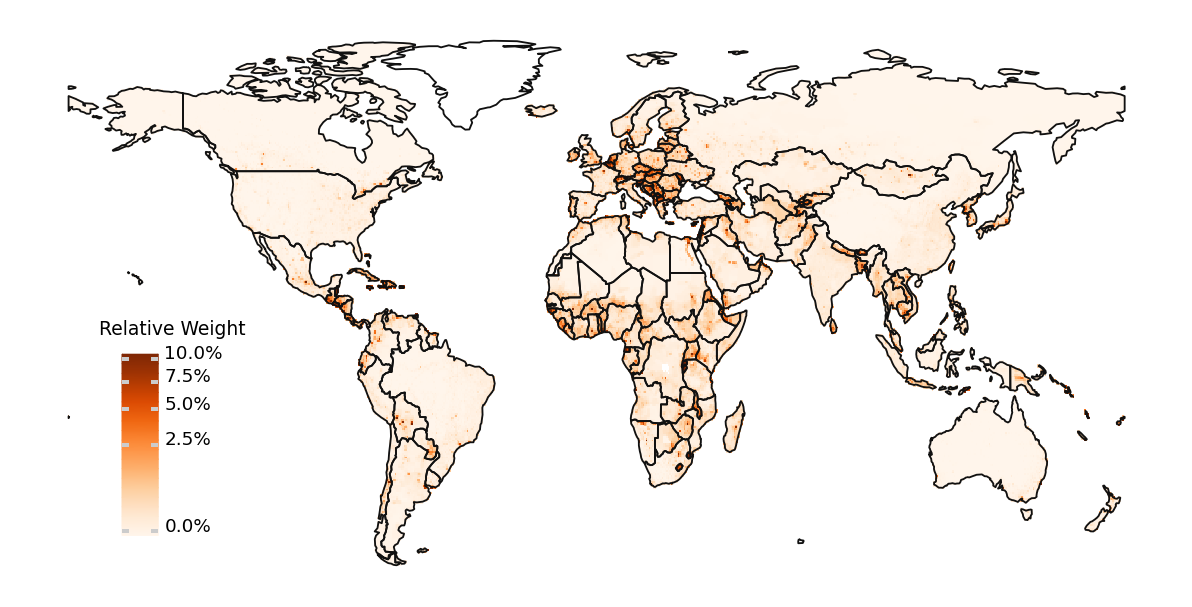

<ggplot: (8736895249942)>

In [37]:
f = (p9.ggplot(weighted_cells) 
     + p9.aes('longitude', 'latitude', fill='relative_weight')
     + p9.geom_tile()
     + p9.geom_map(data=world, inherit_aes=False, alpha=0)
     + p9.scale_fill_continuous('Oranges', trans='sqrt', labels=percent_format(), limits=(0, .1))
     + p9.theme_void()
     + p9.labs(fill='Relative Weight')
     + p9.theme(figure_size=(10, 5), legend_position=(.23, .33), legend_key_size=12,
                legend_title_align='center', legend_title=p9.element_text(size=9)) 
)

p9.ggsave(f, '../../results/figures/rw_map.pdf')
f

### Selection of relevant dates

In [38]:
cases_threshold = 20
day_over_threshold = (covid_df
                       .loc[covid_df.cumulative_cases>=cases_threshold]
                       .groupby('iso3')
                       ['date']
                       .first()
                       .pipe(pd.to_datetime)
                       .loc[lambda x: x < '2020-07-22']
                  )

In [39]:
days_of_interest = (pd.concat([(day_over_threshold + pd.to_timedelta(f'{i} days'))
                               .reset_index() 
                               for i in range(-10, 11)])
                    .sort_values(['iso3', 'date'])
                   )

### Weather averages for the selected days

In [40]:
selected_wcdf = (weighted_climate_df
                 .merge(days_of_interest, on=['date', 'iso3'])
                 .groupby('iso3', as_index=False)
                 .mean()
                )

The ECDC has updated the dataset retrospectively, making some countries pass the threshold now which
didn't before (Kosovo, Dominican Republic). In order to keep things reproducible, I will manually delete
those.

In [41]:
selected_wcdf = selected_wcdf.loc[lambda dd: ~dd.iso3.isin(['XKX', 'DOM'])]

Singapore is too small to be assigned its own 0.5x0.5 grid, so we will just use the weather of the
grid cell containing its centroid.

In [42]:
country_to_iso = (country_to_iso
                  .append(pd.Series(['Singapore', 'SGP'],
                                    index=['country', 'iso3'])
                          .to_dict(), ignore_index=True)
                 )

In [43]:
weather_sgp = (climate_df.query('latitude == 1.5 & longitude == 103.5')
                .assign(country='Singapore')
                .merge(country_to_iso)
                .merge(days_of_interest)
                .groupby(['iso3'], as_index=False)
                .mean()
                 [['iso3', 'temperature', 'absolute_humidity']]
              )

In [44]:
selected_wcdf = selected_wcdf.append(weather_sgp).reset_index(drop=True)

#### Generating figures

/home/afontal/.cache/pypoetry/virtualenvs/covid-climate-signatures-fALnqXQj-py3.8/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 10 x 5 in image.
/home/afontal/.cache/pypoetry/virtualenvs/covid-climate-signatures-fALnqXQj-py3.8/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../../results/figures/t_map.pdf


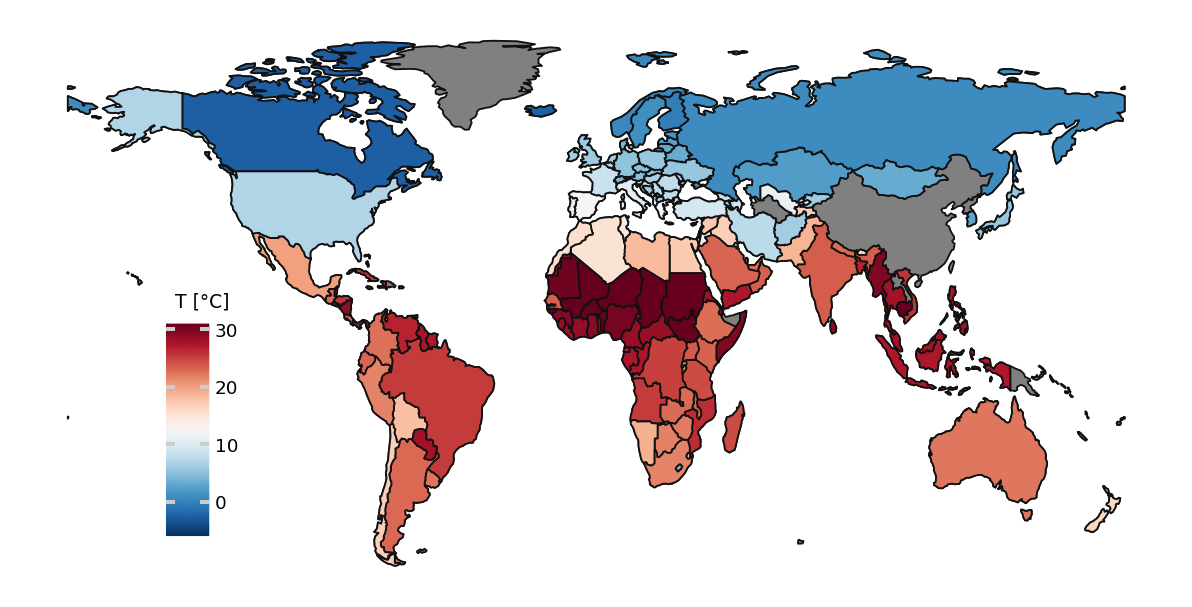

<ggplot: (8736895134772)>

In [45]:
f_t = (selected_wcdf
       .merge(world)
 .pipe(lambda dd: p9.ggplot(dd) 
      + p9.aes(fill='temperature')
      + p9.geom_map(data=world, fill='gray')
      + p9.geom_map()
      + p9.scale_fill_continuous('RdBu_r', limits=(-5, 30))
      + p9.theme_void()
      + p9.labs(fill='T [°C]')
      + p9.theme(figure_size=(10, 5), legend_position=(.25, .35), legend_key_size=14,
                 legend_title_align='center', legend_title=p9.element_text(size=9)) )
)
p9.ggsave(f_t, '../../results/figures/t_map.pdf')
f_t

/home/afontal/.cache/pypoetry/virtualenvs/covid-climate-signatures-fALnqXQj-py3.8/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 10 x 5 in image.
/home/afontal/.cache/pypoetry/virtualenvs/covid-climate-signatures-fALnqXQj-py3.8/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../../results/figures/ah_map.pdf


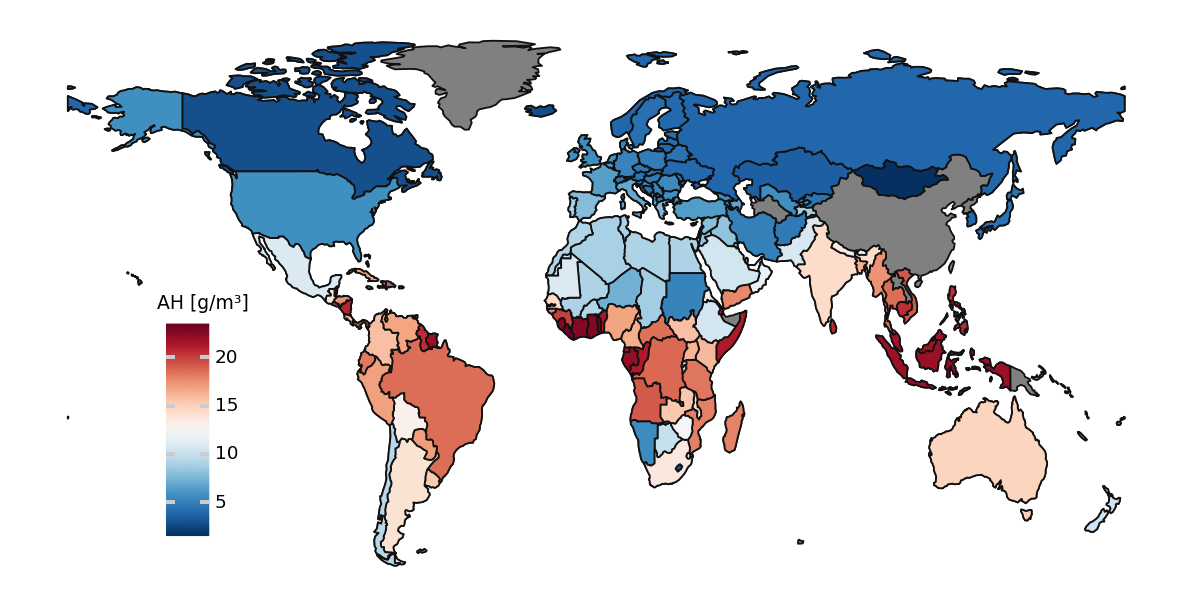

<ggplot: (8736895026667)>

In [46]:
f_ah = (selected_wcdf
 .merge(world)
 .pipe(lambda dd: p9.ggplot(dd) 
      + p9.aes(fill='absolute_humidity')
      + p9.geom_map(data=world, fill='gray')
      + p9.geom_map()
      + p9.scale_fill_continuous('RdBu_r')
      + p9.theme_void()
      + p9.labs(fill='AH [g/m³]')
      + p9.theme(figure_size=(10, 5), legend_position=(.25, .35), legend_key_size=14,
                 legend_title_align='center', legend_title=p9.element_text(size=9)) )
)
p9.ggsave(f_ah, '../../results/figures/ah_map.pdf')
f_ah

## $R_0$ Estimation 

In [47]:
max_days = 20
min_days = 20
min_cases = 20
cfc = CountryFittedComparison(df=covid_df,
                              country_col='iso3',
                              cases_col='cumulative_cases',
                              max_days=max_days,
                              log_norm=True,
                              min_cases=min_cases,
                              min_days=min_days)

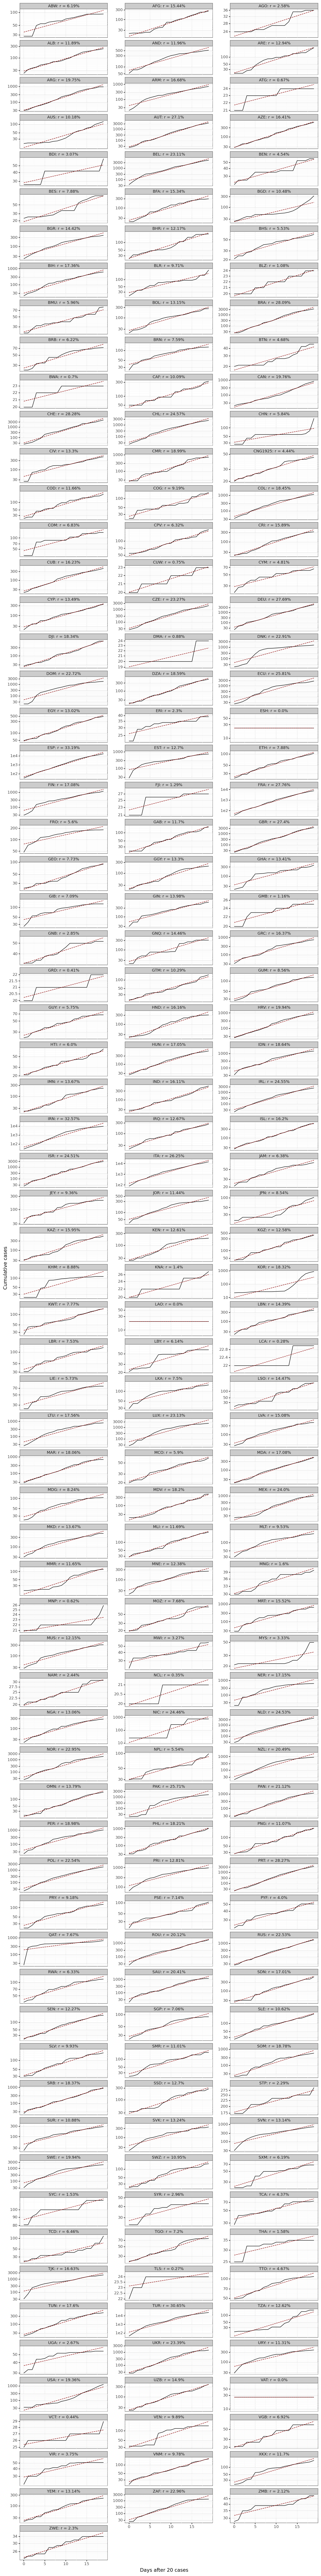

<ggplot: (8736894882669)>

In [48]:
cfc.plot_countries_comparison(min_days=20, log_scale=True)

In [49]:
full_df = (selected_wcdf
           .merge(cfc.country_pars_df)
           .assign(r0=lambda dd: dd.r * 4.7 + 1)
          )

full_df.to_csv('../../results/tables/initial_wave_full_table.csv', index=False)

/home/afontal/.cache/pypoetry/virtualenvs/covid-climate-signatures-fALnqXQj-py3.8/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 10 x 5 in image.
/home/afontal/.cache/pypoetry/virtualenvs/covid-climate-signatures-fALnqXQj-py3.8/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../../results/figures/r0_map.pdf


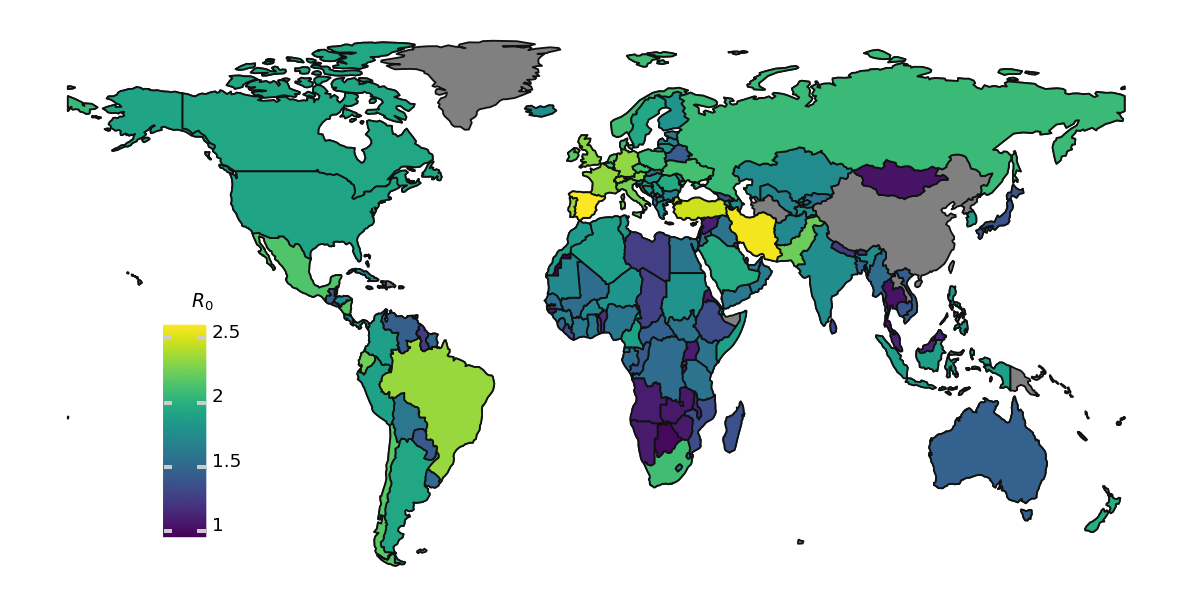

<ggplot: (8736845962984)>

In [50]:
f_r = (full_df
       .merge(world)
       .pipe(lambda dd: p9.ggplot(dd) 
              + p9.aes(fill='r0')
              + p9.geom_map(data=world, fill='gray')
              + p9.geom_map()
              + p9.theme_void()
              + p9.labs(fill='$R_0$')
              + p9.theme(figure_size=(10, 5), legend_position=(.25, .35), legend_key_size=14,
                         legend_title_align='center', legend_title=p9.element_text(size=9)) )
)
p9.ggsave(f_r, '../../results/figures/r0_map.pdf')
f_r

## $R_0$ ~ weather comparison

### Temperature

In [51]:
lm_t = smf.ols('r0 ~ temperature', data=full_df).fit()

In [52]:
lm_t.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     r0   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     42.27
Date:                Thu, 27 May 2021   Prob (F-statistic):           9.63e-10
Time:                        16:32:19   Log-Likelihood:                -44.316
No. Observations:                 162   AIC:                             92.63
Df Residuals:                     160   BIC:                             98.81
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.9680      0.055     36.003      0.000       1.860       2.076
temperature    -0.0174      0.003     -6.502      0.000      -0.023      -0.012
==============================================================================
Omnibus:                        2.333   Durbin-Watson:                   1.673
Prob(Omnibus):                  0.311   Jarque-Bera (JB):                2.195
Skew:                           0.205   Prob(JB):                        0.334
Kurtosis:                       2.604   Cond. No.                         44.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
with open('../../results/tables/lm_t_r0.txt', 'w') as fh:
    fh.write(lm_t.summary2().as_text())

/home/afontal/.cache/pypoetry/virtualenvs/covid-climate-signatures-fALnqXQj-py3.8/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 5 x 3 in image.
/home/afontal/.cache/pypoetry/virtualenvs/covid-climate-signatures-fALnqXQj-py3.8/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../../results/figures/lm_t.pdf


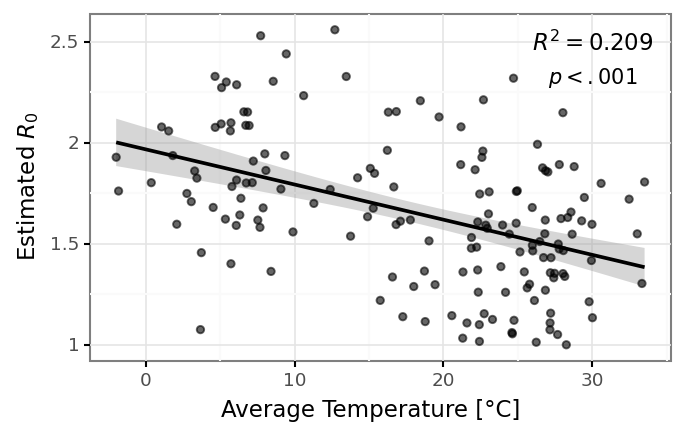

<ggplot: (8736845819471)>

In [54]:
f_lm_t = full_df.pipe(lambda dd: p9.ggplot(dd)
             + p9.aes('temperature', 'r0') 
             + p9.geom_smooth(method='lm', group=1)
             + p9.geom_point(alpha=.6)
             + p9.theme(figure_size=(5, 3), dpi=150)
             + p9.labs(x='Average Temperature [°C]', y='Estimated $R_0$')
             + p9.annotate(x=30, y=2.5, label=fr'$R^2 = {lm_t.rsquared.round(3)}$', geom='text')
             + p9.annotate(x=30, y=2.325, label=fr'$p < .001$', geom='text', size=10)

 )
p9.ggsave(f_lm_t, '../../results/figures/lm_t.pdf')
f_lm_t

### Absolute Humidity

In [55]:
lm_ah = smf.ols('r0 ~ absolute_humidity', data=full_df).fit()

In [56]:
lm_ah.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     r0   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     32.55
Date:                Thu, 27 May 2021   Prob (F-statistic):           5.47e-08
Time:                        16:32:20   Log-Likelihood:                -48.306
No. Observations:                 162   AIC:                             100.6
Df Residuals:                     160   BIC:                             106.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.9492      0.058     33.577      0.000       1.835       2.064
absolute_humidity    -0.0246      0.004     -5.706      0.000      -0.033      -0.016
==============================================================================
Omnibus:                        0.727   Durbin-Watson:                   1.592
Prob(Omnibus):                  0.695   Jarque-Bera (JB):                0.849
Skew:                           0.140   Prob(JB):                        0.654
Kurtosis:                       2.782   Cond. No.                         30.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
with open('../../results/tables/lm_ah_r0.txt', 'w') as fh:
    fh.write(lm_ah.summary2().as_text())

/home/afontal/.cache/pypoetry/virtualenvs/covid-climate-signatures-fALnqXQj-py3.8/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 5 x 3 in image.
/home/afontal/.cache/pypoetry/virtualenvs/covid-climate-signatures-fALnqXQj-py3.8/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../../results/figures/lm_ah.pdf


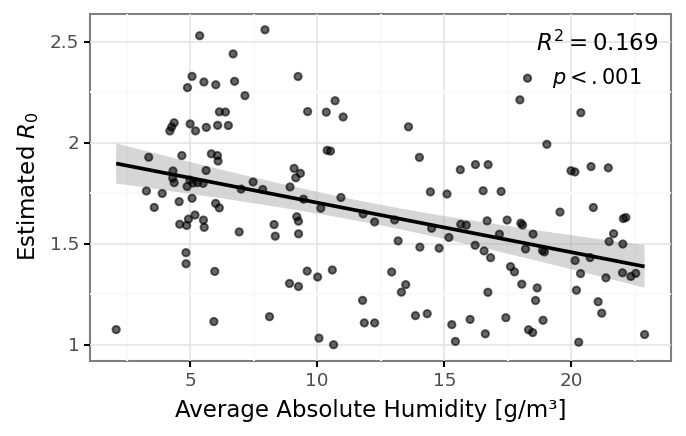

<ggplot: (8736896385856)>

In [58]:
f_lm_ah = full_df.pipe(lambda dd: p9.ggplot(dd)
             + p9.aes('absolute_humidity', 'r0') 
             + p9.geom_smooth(method='lm', group=1)
             + p9.geom_point(alpha=.6)
             + p9.theme(figure_size=(5, 3), dpi=150)
             + p9.labs(x='Average Absolute Humidity [g/m³]', y='Estimated $R_0$')
             + p9.annotate(x=21, y=2.5, label=fr'$R^2 = {lm_ah.rsquared.round(3)}$', geom='text')
             + p9.annotate(x=21, y=2.325, label=fr'$p < .001$', geom='text', size=10)

 )
p9.ggsave(f_lm_ah, '../../results/figures/lm_ah.pdf')
f_lm_ah

### Sensitivity analysis

In [59]:
from src.fits import CountryFittedComparison

In [60]:
weather_sgp = (climate_df.query('latitude == 1.5 & longitude == 103.5')
                .assign(country='Singapore')
                .merge(country_to_iso)
              )
params_sensitivity_dict = defaultdict(list)
for cases_threshold in range(15, 50, 5):
    for fitted_days in range(18, 28):
        day_over_threshold = (
            covid_df
            .loc[covid_df.cumulative_cases>=cases_threshold]
            .groupby('iso3')
            ['date']
            .first()
            .pipe(pd.to_datetime))
        
        days_of_interest = (pd.concat([(day_over_threshold + pd.to_timedelta(f'{i} days'))
                               .reset_index() 
                               for i in range(-10, 11)])
                    .sort_values(['iso3', 'date']))
        
        weather_sgp = (weather_sgp.merge(days_of_interest)
                        .groupby(['iso3'], as_index=False)
                        .mean()
                        [['iso3', 'temperature', 'absolute_humidity']]
                      )
        selected_wcdf = (weighted_climate_df
                         .merge(days_of_interest, on=['date', 'iso3'])
                         .groupby('iso3', as_index=False)
                         .mean()
                         .loc[lambda dd: ~dd.iso3.isin(['XKX', 'DOM'])]
                         .append(weather_sgp)
                )

        cfc = CountryFittedComparison(df=covid_df,
                                      country_col='iso3',
                                      cases_col='cumulative_cases',
                                      max_days=fitted_days,
                                      log_norm=True,
                                      min_cases=cases_threshold,
                                      min_days=fitted_days)
        
        full_df = (selected_wcdf
                   .merge(cfc.country_pars_df)
                   .assign(r0=lambda dd: dd.r * 4.7 + 1)
                  )
        
        for weather_variable in ['temperature', 'absolute_humidity']:
            lm = smf.ols(f'r0 ~ {weather_variable}', data=full_df).fit()
            params_sensitivity_dict['weather_variable'].append(weather_variable)
            params_sensitivity_dict['cases_threshold'].append(cases_threshold)
            params_sensitivity_dict['fitted_days'].append(fitted_days)
            params_sensitivity_dict['r_squared'].append(lm.rsquared)
            params_sensitivity_dict['p_value'].append(lm.pvalues[weather_variable])
            params_sensitivity_dict['intercept'].append(lm.params.Intercept)
            params_sensitivity_dict['slope'].append(lm.params[weather_variable])
            params_sensitivity_dict['lower_b'].append(lm.conf_int()[0][weather_variable])
            params_sensitivity_dict['upper_b'].append(lm.conf_int()[1][weather_variable])
            params_sensitivity_dict['upper_m'].append(lm.conf_int()[1].Intercept)
            params_sensitivity_dict['lower_m'].append(lm.conf_int()[0].Intercept)
            
sensitivity_df = pd.DataFrame(params_sensitivity_dict)

In [61]:
sensitivity_df.to_csv('../../results/tables/params_sensitivity.csv', index=False)

In [62]:
lms_df = []
for i, row in sensitivity_df.iterrows():
    m = row.slope
    b = row.intercept
    variable = row.weather_variable
    x = np.arange(-5, 35) if variable == 'temperature' else np.arange(-5, 25)
    y = m * x + b
    lms_df.append(pd.DataFrame({'x': x, 'y': y, 'variable': variable})
                  .assign(label=f'Days={row.fitted_days}, Cases={row.cases_threshold}')
                 
)
lms_df = pd.concat(lms_df)

/home/afontal/.cache/pypoetry/virtualenvs/covid-climate-signatures-fALnqXQj-py3.8/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 11 in image.
/home/afontal/.cache/pypoetry/virtualenvs/covid-climate-signatures-fALnqXQj-py3.8/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../../results/figures/sensitivity_betas.pdf


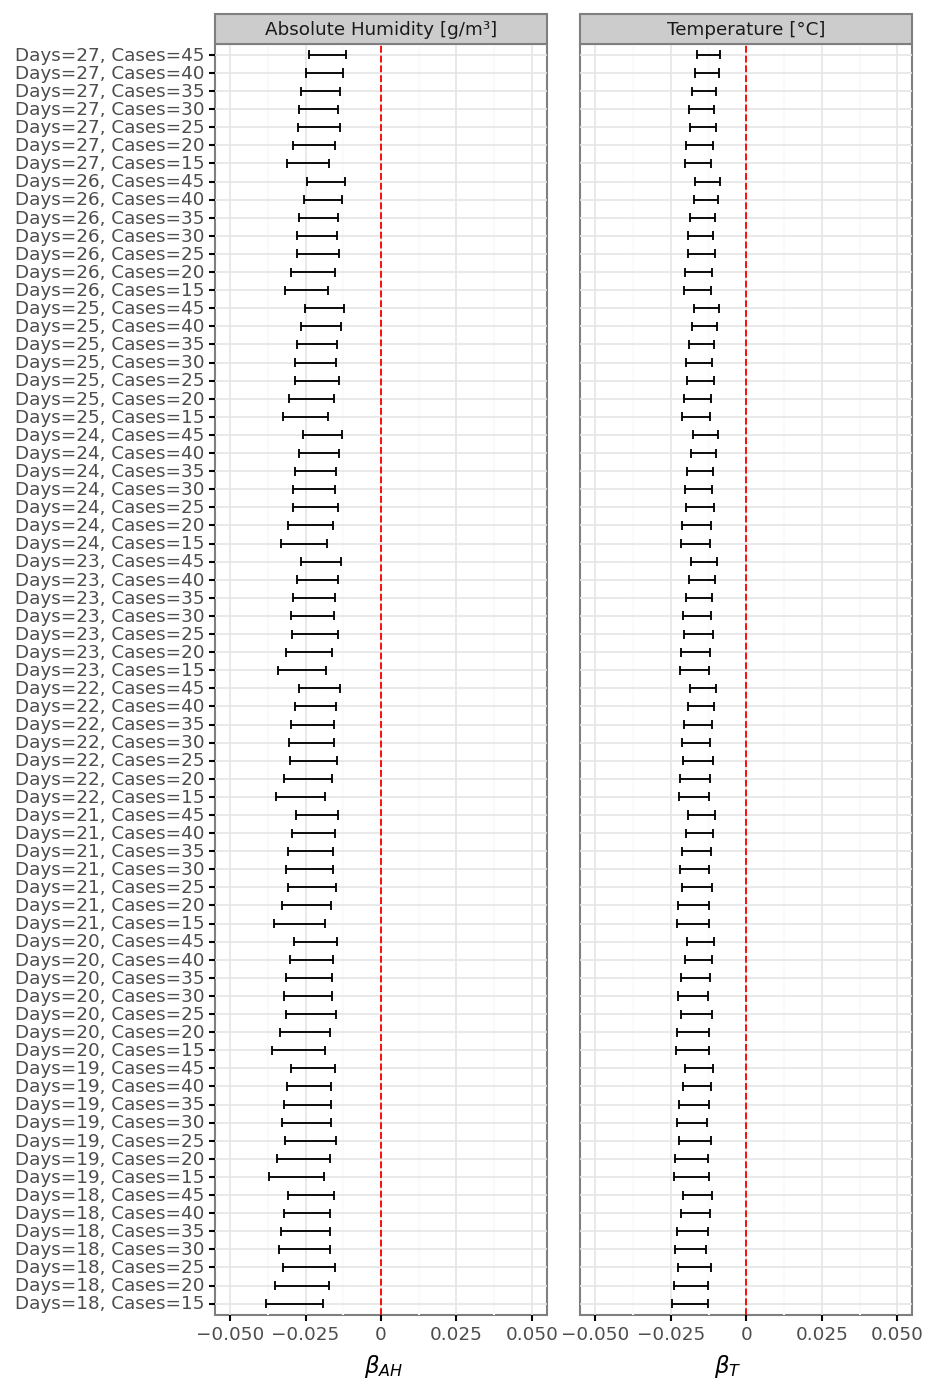

<ggplot: (8736830607647)>

In [63]:
f = (sensitivity_df
 .replace(CV_LABELS)
 .assign(label=lambda dd: 'Days=' + dd.fitted_days.astype(str) + 
         ', Cases=' + dd.cases_threshold.astype(str))
  .pipe(lambda dd: (p9.ggplot(dd) 
                   + p9.aes(x='label', ymax='upper_b', ymin='lower_b') 
                   + p9.geom_errorbar())
                   + p9.coord_flip()
                   + p9.facet_wrap('weather_variable')
                   + p9.labs(x='', y='$\\beta_{AH}\qquad \qquad \qquad \qquad'
                             '\qquad \qquad \qquad \\beta_{T}$')
                   + p9.theme(figure_size=(6, 11), subplots_adjust={'wspace': .1})
                   + p9.ylim(-.05, .05)
                   + p9.geom_hline(yintercept=0, linetype='dashed', color='red')
      )
)
p9.ggsave(f, '../../results/figures/sensitivity_betas.pdf')
f

/home/afontal/.cache/pypoetry/virtualenvs/covid-climate-signatures-fALnqXQj-py3.8/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3 x 3 in image.
/home/afontal/.cache/pypoetry/virtualenvs/covid-climate-signatures-fALnqXQj-py3.8/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../../results/figures/sensitivity_r2s.pdf


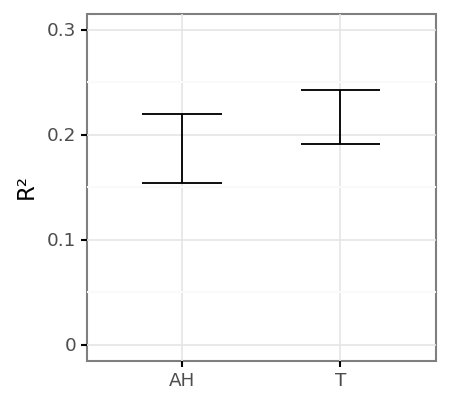

<ggplot: (8736895331398)>

In [64]:
f = (sensitivity_df
     .replace({'temperature': 'T', 'absolute_humidity': 'AH'})
     .groupby('weather_variable')
     .r_squared
     .agg(['min', 'max'])
     .reset_index()
     .pipe(lambda dd: p9.ggplot(dd) 
       + p9.aes('weather_variable', ymin='min', ymax='max') 
       + p9.geom_errorbar()
       + p9.ylim(0, .3)
       + p9.labs(x='', y='R²')
       + p9.theme(dpi=150, figure_size=(3, 3)))
 
)
p9.ggsave(f, '../../results/figures/sensitivity_r2s.pdf')
f

/home/afontal/.cache/pypoetry/virtualenvs/covid-climate-signatures-fALnqXQj-py3.8/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 7 x 3 in image.
/home/afontal/.cache/pypoetry/virtualenvs/covid-climate-signatures-fALnqXQj-py3.8/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../../results/figures/sensitivity_lms.pdf


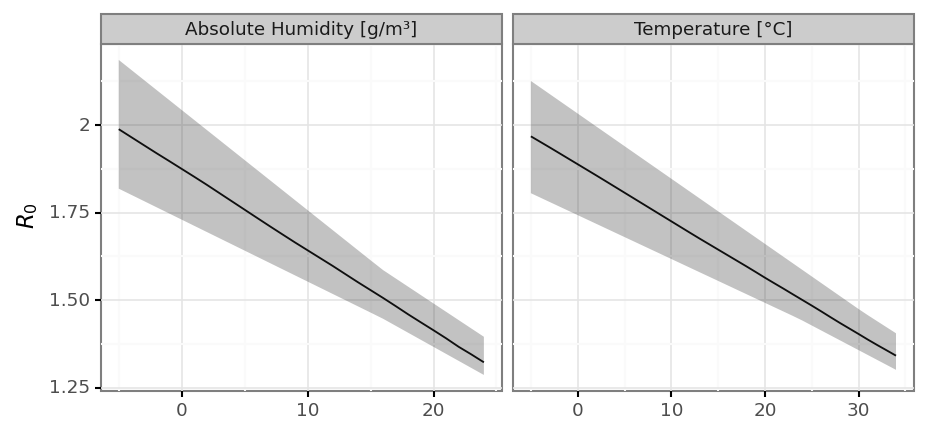

<ggplot: (8736888448615)>

In [65]:
f = (p9.ggplot(lms_df.replace(CV_LABELS))
 + p9.aes(x='x', y='y') 
 + p9.stat_summary(fun_y=np.median, geom='line')
 + p9.stat_summary(fun_ymax=np.max, fun_ymin=np.min, geom='ribbon', alpha=.3)
 + p9.facet_wrap('variable', scales='free_x')
 + p9.theme(figure_size=(7, 3))
 + p9.labs(x='', y='$R_0$')
)
p9.ggsave(f, '../../results/figures/sensitivity_lms.pdf')
f